+---------+--------------+---------------+--------+
|   month |   units_used |   temperature |   bill |
+=========+==============+===============+========+
|       1 |          120 |            26 |    360 |
+---------+--------------+---------------+--------+
|       2 |          140 |            28 |    420 |
+---------+--------------+---------------+--------+
|       3 |          160 |            30 |    500 |
+---------+--------------+---------------+--------+
|       4 |          180 |            33 |    580 |
+---------+--------------+---------------+--------+
|       5 |          220 |            36 |    700 |
+---------+--------------+---------------+--------+
|       6 |          260 |            39 |    820 |
+---------+--------------+---------------+--------+
|       7 |          310 |            42 |    980 |
+---------+--------------+---------------+--------+
|       8 |          300 |            41 |    940 |
+---------+--------------+---------------+--------+
|       9 | 

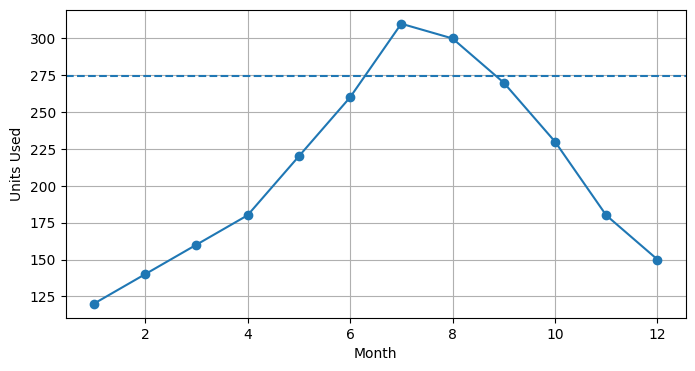

In [2]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from joblib import dump, load
from tabulate import tabulate

data = {
    "month": list(range(1, 13)),
    "units_used": [120, 140, 160, 180, 220, 260, 310, 300, 270, 230, 180, 150],
    "temperature": [26, 28, 30, 33, 36, 39, 42, 41, 38, 34, 30, 27],
    "bill": [360, 420, 500, 580, 700, 820, 980, 940, 860, 740, 560, 460]
}

df = pd.DataFrame(data)

print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

df["avg_units"] = df["units_used"].rolling(3).mean().fillna(df["units_used"])
df["season"] = df["month"].apply(lambda x: 1 if x in [3,4,5,6] else 0)

print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

X = df[["units_used", "temperature", "avg_units", "season"]]
y = df["bill"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_error = mean_absolute_error(y_test, lr_pred)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_error = mean_absolute_error(y_test, rf_pred)

model_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [lr_error, rf_error]
})

print(tabulate(model_comparison, headers="keys", tablefmt="grid", showindex=False))

if rf_error < lr_error:
    final_model = rf
    model_name = "Random Forest"
    error = rf_error
else:
    final_model = lr
    model_name = "Linear Regression"
    error = lr_error

dump(final_model, "best_bill_model.pkl")

model_result_df = pd.DataFrame({
    "Selected Model": [model_name],
    "Mean Absolute Error": [round(error, 2)]
})

print(tabulate(model_result_df, headers="keys", tablefmt="grid", showindex=False))

units = float(input("Enter units used: "))
temp = float(input("Enter avg temperature: "))
avg_units = float(input("Enter last 3 months avg units: "))
season = int(input("Summer season? (1=Yes, 0=No): "))

model = load("best_bill_model.pkl")
prediction = model.predict([[units, temp, avg_units, season]])

prediction_df = pd.DataFrame({
    "Units Used": [units],
    "Temperature": [temp],
    "Avg Units (3 months)": [avg_units],
    "Season": [season],
    "Predicted Bill": [int(prediction[0])]
})

print(tabulate(prediction_df, headers="keys", tablefmt="grid", showindex=False))

threshold = df["units_used"].mean() + df["units_used"].std()
df["high_usage"] = df["units_used"] > threshold

high_usage_df = df[df["high_usage"] == True][["month", "units_used"]]

print(tabulate(high_usage_df, headers="keys", tablefmt="grid", showindex=False))

plt.figure(figsize=(8,4))
plt.plot(df["month"], df["units_used"], marker='o')
plt.axhline(threshold, linestyle='--')
plt.xlabel("Month")
plt.ylabel("Units Used")
plt.grid()
plt.show()